In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
from data_access.load_file import load_table
from data_processing.functions import time_for_phase
from data_preparation import compute_work_item_times
from data_processing import features
from modeling.evaluation import train_test_predictions, plot_train_test
from evaluate import rmsle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge

First we load the data and features.

In [3]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
times = time_for_phase(data)
total_times = compute_work_item_times(data)
work_times = features.work_times(times, time_col="duration_in_days")
work_frequency = features.work_times(times)
process_length = features.process_length(times)
is_open = features.is_open(data)

Now we load the outlier predicition from notebook 6_outlier_prediction

In [4]:
filename = Path("../data/outlier_prediction.csv")
outliers = pd.read_csv(filename)
outliers.rename(columns={"predictions": "outlier_pred"}, inplace=True)

Now we load the predicted process frequencies of the open work tickets from notebook 9_path_learning

In [5]:
filename = Path("../data/path_learning.csv")
open_frequency = pd.read_csv(filename)

We want to "merge" the predicted path frequency with the already existing frequency by chosing the maximum value

In [6]:
open_wis = is_open[is_open["is_open"]==1]["work_item"].values
newfreq = pd.merge(work_frequency[work_frequency.work_item.isin(open_wis)], open_frequency, on="work_item")
freq_cols = ['Accept_freq', 'Analyze_freq', 'Build_freq', 'Clarify_freq', 'Deploy_freq', 'Design_freq', 'End_freq', 'Package_freq', 'Test_freq']
for x, y in newfreq.iterrows():
    for col in freq_cols:
        if y[col+"_x"] > y[col+"_y"]:
            newfreq.loc[x, col] = y[col+"_x"]
        else:
            if y[col+"_y"] > 0:
                newfreq.loc[x, col] = y[col+"_y"]
            else:
                newfreq.loc[x, col] = 0

In [7]:
work_frequency = pd.concat([work_frequency[~work_frequency["work_item"].isin(open_wis)], newfreq[["work_item", *freq_cols]]])

After that we can merge everything together

In [34]:
final = reduce(lambda x, y: pd.merge(x, y, on="work_item", how="inner"),
               [work_times, work_frequency, process_length, is_open, outliers, total_times[["work_item", "duration_in_days"]]])

Now we add the other given features like domain, work_priority, work_type, ...

In [35]:
final.drop_duplicates("work_item", inplace=True)
final.set_index("work_item", inplace=True)
cols_to_encode = ["domain", "work_priority", "work_type", "platform"]
encode = data[["work_item", *cols_to_encode]].drop_duplicates("work_item")
encoded = pd.get_dummies(encode, columns=cols_to_encode)
final = pd.merge(final, encoded, left_index=True, right_on="work_item").set_index("work_item")
final.head()

,Accept,Analyze,Build,Clarify,Deploy,Design,End,Package,Test,Accept_freq,...,platform_PL_00010,platform_PL_00011,platform_PL_00012,platform_PL_00013,platform_PL_00014,platform_PL_00015,platform_PL_00016,platform_PL_00017,platform_PL_00018,platform_PL_00019
work_item,,,,,,,,,,,,,,,,,,,,,
WI_000001,1.10,4.82,5.83,0.0,7.02,0.17,0.0,3.91,2.03,1.0,...,0,0,0,0,0,0,0,0,0,0
WI_000002,0.00,11.78,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
WI_000003,0.00,44.89,0.00,0.0,0.00,6.88,0.0,0.00,3.08,0.0,...,0,0,0,0,0,0,0,0,0,0
WI_000004,2.05,11.80,0.00,0.0,11.89,0.00,0.0,0.00,0.00,1.0,...,0,0,0,0,0,0,0,0,0,0
WI_000005,0.05,25.69,0.98,0.0,6.10,0.03,0.0,0.00,0.00,1.0,...,0,0,0,0,0,0,0,0,0,0


Looks fine, now we are going to split into train and test dataset

In [36]:
is_open = final["is_open"]==1
times_open = final[is_open]
times_closed = final[~is_open]
print("We have %i open work_items and %i closed work_items"%(len(times_open), len(times_closed)))

We have 1042 open work_items and 10522 closed work_items


In [37]:
x_data = times_closed[list(set(times_closed.columns) - set(["duration_in_days", "has_end"]))]
y_data = pd.DataFrame(times_closed["duration_in_days"])
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

In [38]:
print("Train data shape = {}".format(x_train.shape))
print("Test data shape = {}".format(x_test.shape))

Train data shape = (7365, 59)
Test data shape = (3157, 59)


Let's initialize the model and fit the data into it

In [39]:
bay = BayesianRidge(n_iter=500)
fit = bay.fit(x_train, y_train)

We want to take a look at the importances of the features

In [40]:
sorted(list(zip(x_train.columns, fit.coef_)), key=(lambda x: x[1]), reverse=True)

[('Deploy', 1.0000036180800023),
 ('Test', 0.9999984489981),
 ('Build', 0.9999979983674727),
 ('Analyze', 0.999997676465606),
 ('Design', 0.999996655478341),
 ('Accept', 0.9999948908345531),
 ('Package', 0.9999759723713125),
 ('Clarify', 0.9916934883221984),
 ('Clarify_freq', 0.08990525221452117),
 ('process_length', 0.01134936511516571),
 ('platform_PL_00014', 0.001091228798031807),
 ('domain_BD_00008', 0.0009397659450769424),
 ('platform_PL_00015', 0.0006126072257757187),
 ('outlier_pred', 0.0005421401320546693),
 ('domain_BD_00001', 0.00038058124482631683),
 ('platform_PL_00001', 0.0003739111125469208),
 ('platform_PL_00004', 0.0003022262826561928),
 ('platform_PL_00012', 0.0002327989786863327),
 ('work_type_WT_00002', 0.000223502516746521),
 ('work_priority_WP_00004', 0.00018674135208129883),
 ('work_priority_WP_00002', 0.00016874819993972778),
 ('work_priority_WP_00001', 5.718320608139038e-05),
 ('platform_PL_00009', 2.4121254682540894e-05),
 ('platform_PL_00010', 1.06617808341979

We can see that the phases are featured as 1 which is logical because their values are the time so we should also get perfect predictions for training and test set. Validation set could be super bad.

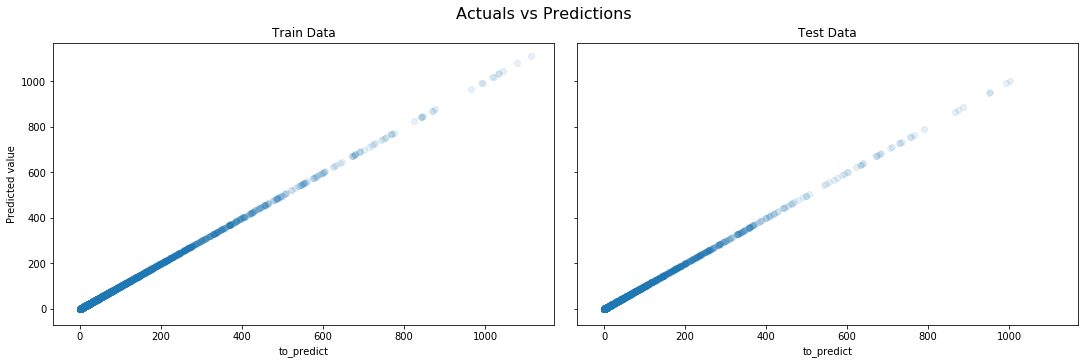

In [43]:
train_predictions, test_predictions = train_test_predictions(x_train, x_test, fit, val=None)
plot_train_test(train_predictions, y_train, test_predictions, y_test, col="duration_in_days")

In [44]:
train_rmsle = rmsle(y_train.reset_index(), train_predictions)
test_rmsle = rmsle(y_test.reset_index(), test_predictions)
print("Train error is %f" %train_rmsle)
print("Test error is %f" %test_rmsle)

Train error is 0.001502
Test error is 0.001536


Model and Error is low as well. But the other features are have an impact to. So we compare out predictions with the time they already took.

In [45]:
predict_df = times_open[list(set(times_open.columns) - set(["duration_in_days", "has_end"]))]
submit_predictions = pd.DataFrame(predict_df.index)
submit_predictions["predictions"] = fit.predict(predict_df)

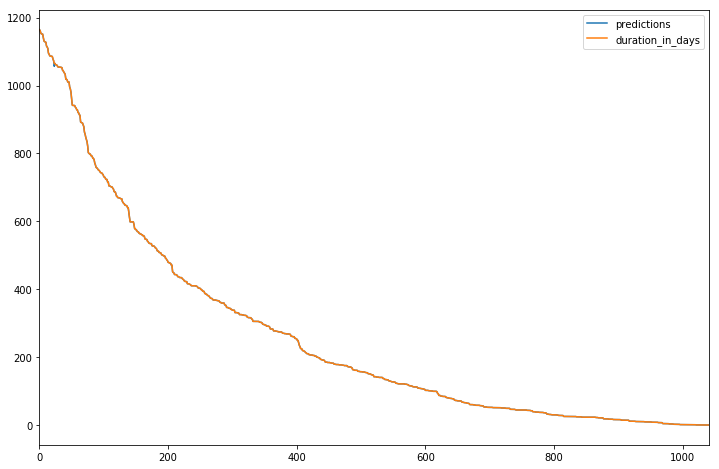

In [46]:
wt_plot = work_times.copy()
wt_plot["duration_in_days"] = wt_plot.sum(axis=1)
mer = pd.merge(submit_predictions, wt_plot[["work_item", "duration_in_days"]], on="work_item")
mer.plot(figsize=(12,8))